# [Paris Saclay Center for Data Science](http://www.datascience-paris-saclay.fr)

## [Fake news RAMP](http://www.ramp.studio/problems/fake_news): classify statements of public figures

_Emanuela Boros (LIMSI/CNRS), Balázs Kégl (LAL/CNRS), Roman Yurchak (Symerio)_

## Introduction
This is an initiation project to introduce RAMP and get you to know how it works.

The goal is to develop prediction models able to **identify which news is fake**. 

The data we will manipulate is from http://www.politifact.com. The input contains of short statements made by public figures (and sometimes anonymous bloggers), plus some metadata. The output is a truth level, judged by journalists at Politifact. They use six truth levels which we coded into integers to obtain an [ordinal regression](https://en.wikipedia.org/wiki/Ordinal_regression) problem:
```
0: 'Pants on Fire!'
1: 'False'
2: 'Mostly False'
3: 'Half-True'
4: 'Mostly True'
5: 'True'
```
You goal is to classify each statement (+ metadata) into one of the categories.

### Requirements

* numpy>=1.10.0  
* matplotlib>=1.5.0 
* pandas>=0.19.0  
* scikit-learn>=0.17 (different syntaxes for v0.17 and v0.18)   
* seaborn>=0.7.1
* nltk

Further, an nltk dataset needs to be downloaded:

```
python -m nltk.downloader popular
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Exploratory data analysis

### Loading the data

In [2]:
train_filename = 'data/train.csv'
data = pd.read_csv(train_filename, sep='\t')
data = data.fillna('')
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,edited_by,job,researched_by,source,state,statement,subjects,truth
0,2013-08-29,Angie Drobnic Holan,Republican,Jon Greenberg,Scott Walker,Wisconsin,"In the Wisconsin health insurance exchange, ""t...",['Health Care'],3
1,2013-08-29,Angie Drobnic Holan,Republican,Louis Jacobson,Mike Huckabee,Arkansas,"""America’s gun-related homicide rate … would b...","['Crime', 'Guns', 'Pundits']",0
2,2013-08-29,Greg Borowski,,Tom Kertscher,League of Conservation Voters,,Says U.S. Sen. Ron Johnson voted to let oil an...,"['Climate Change', 'Energy', 'Environment', 'T...",5
3,2013-08-28,Aaron Sharockman,,Rochelle Koff,National Republican Congressional Committee,,"""Congressman Patrick Murphy voted to keep the ...",['Health Care'],2
4,2013-08-28,Aaron Sharockman,,Angie Drobnic Holan,Janet Napolitano,,"The 2010 DREAM Act failed despite ""strong bipa...","['Bipartisanship', 'Immigration']",2


In [3]:
y_array = data['truth'].values
X_df = data.drop(columns='truth')

In [4]:
X_df.shape

(7569, 8)

In [5]:
y_array.shape

(7569,)

In [6]:
data.dtypes

date             datetime64[ns]
edited_by                object
job                      object
researched_by            object
source                   object
state                    object
statement                object
subjects                 object
truth                     int64
dtype: object

In [7]:
data.describe()

,truth
count,7569.000000
mean,2.740917
std,1.588681
min,0.000000
25%,1.000000
50%,3.000000
75%,4.000000
max,5.000000


In [8]:
data.count()

date             7569
edited_by        7569
job              7569
researched_by    7569
source           7569
state            7569
statement        7569
subjects         7569
truth            7569
dtype: int64

The original training data frame has 13000+ instances. In the starting kit, we give you a subset of 7569 instances for training and 2891 instances for testing.

Most columns are categorical, some have high cardinalities.

['' 'Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'Rhode island'
 'South Carolina' 'South Dakota' 'Tennesse' 'Tennessee' 'Texas'
 'United Kingdom' 'Utah' 'Vermont' 'Virgina' 'Virginia' 'Washington'
 'Washington state' 'Washington, D.C.' 'West Virginia' 'Wisconsin'
 'Wyoming' 'ohio' 'the United States']
60


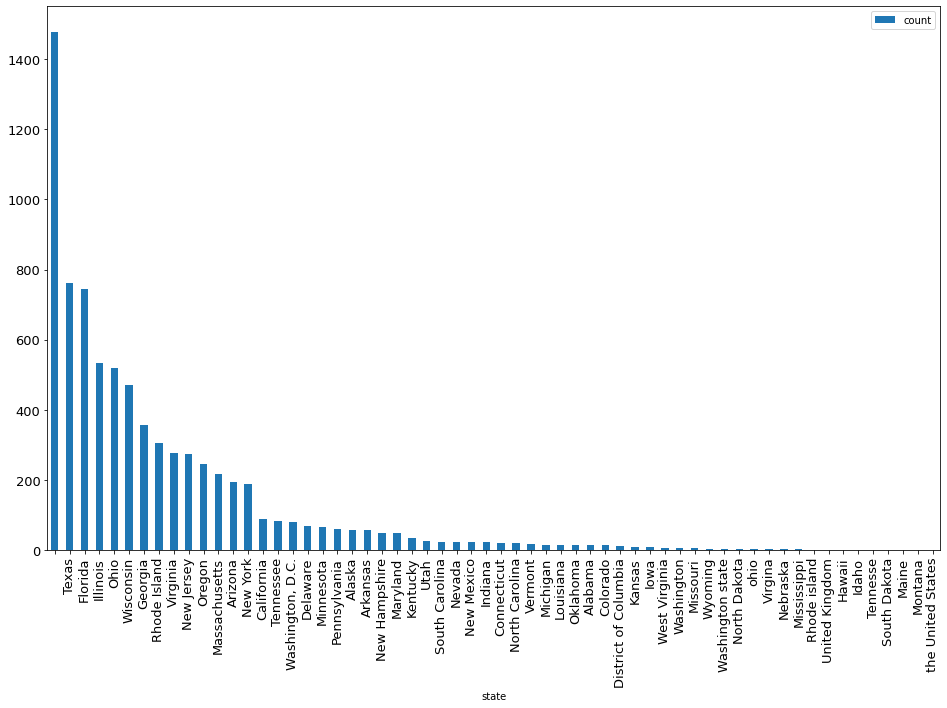

In [9]:
print(np.unique(data['state']))
print(len(np.unique(data['state'])))
data.groupby('state').count()[['job']].sort_values(
    'job', ascending=False).reset_index().rename(
    columns={'job': 'count'}).plot.bar(
    x='state', y='count', figsize=(16, 10), fontsize=13);

['' 'Activist' 'Business leader' 'Columnist' 'Constitution Party'
 'Democrat' 'Democratic Farmer-Labor' 'Independent' 'Journalist'
 'Labor leader' 'Libertarian' 'Newsmaker' 'None'
 'Ocean State Tea Party in Action' 'Organization' 'Republican'
 'State official' 'Talk show host' 'Tea Party member'
 'county commissioner']
20


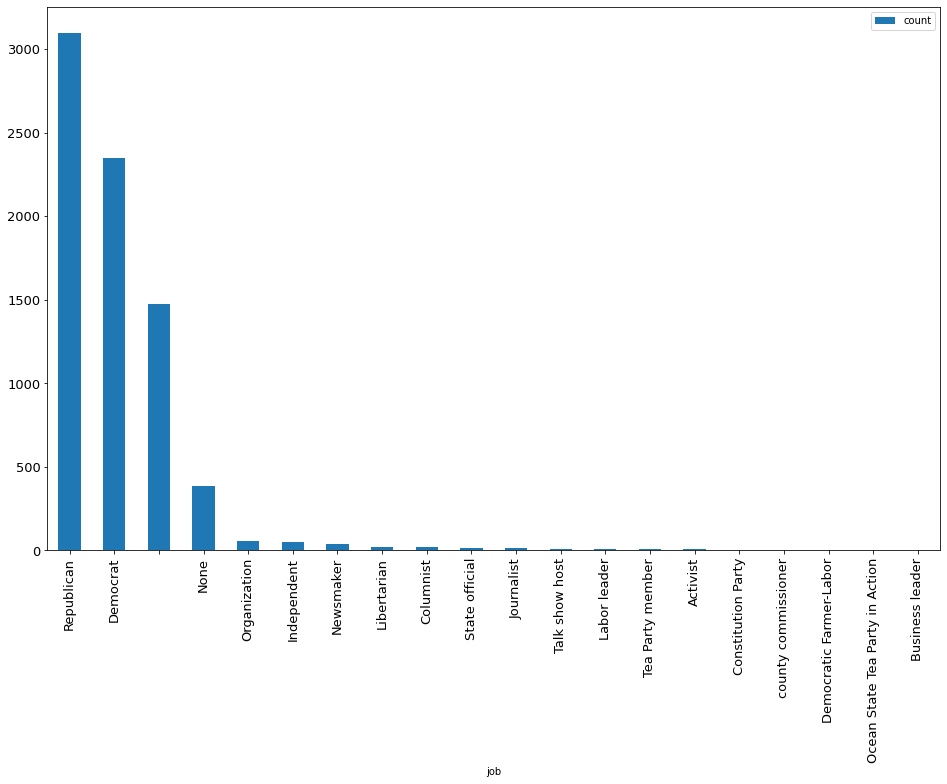

In [10]:
print(np.unique(data['job']))
print(len(np.unique(data['job'])))
data.groupby('job').count()[['state']].rename(
    columns={'state': 'count'}).sort_values(
    'count', ascending=False).reset_index().plot.bar(
        x='job', y='count', figsize=(16, 10), fontsize=13);

If you want to use the journalist and the editor as input, you will need to split the lists since sometimes there are more than one of them on an instance.

['' 'Aaron Sharockman' 'Adriel Bettelheim, Amy Hollyfield'
 'Alexander Lane' 'Amy Hollyfield' 'Amy Hollyfield, Aaron Sharockman'
 'Amy Hollyfield, Greg Joyce' 'Amy Hollyfield, Scott Montgomery'
 'Amy Sherman' 'Angie Drobnic Holan'
 'Angie Drobnic Holan, Aaron Sharockman'
 'Angie Drobnic Holan, Elizabeth Miniet, Jim Tharpe' 'Bill Adair'
 'Bill Adair, Aaron Sharockman' 'Bill Adair, Amy Hollyfield'
 'Bill Adair, Angie Drobnic Holan' 'Bill Adair, Martha M. Hamilton'
 'Bill Adair, Scott Montgomery' 'Bill Adair, Sergio Bustos'
 'Bill Adair, Steve Ahillen, Zack McMillin' 'Bill Adair, Tom Chester'
 'Bill Adair, Tom Chester, Michael Erskine' 'Bill Adair, W. Gardner Selby'
 'Bill Adair, Zack McMillin' 'Bill Duryea' 'Bob Gee' 'Brenda Bell'
 'Brenda Bell, Jody Seaborn' 'Brenda Bell, W. Gardner Selby'
 'Bridget Hall Grumet' 'Bridget Hall Grumet, Angie Drobnic Holan'
 'Bruce  Hammond' 'C. Eugene Emery Jr.' 'Caryn Shinske'
 'Catharine Richert' 'Charles Gay' 'Charles Gay, Elizabeth Miniet'
 'Chris Qui

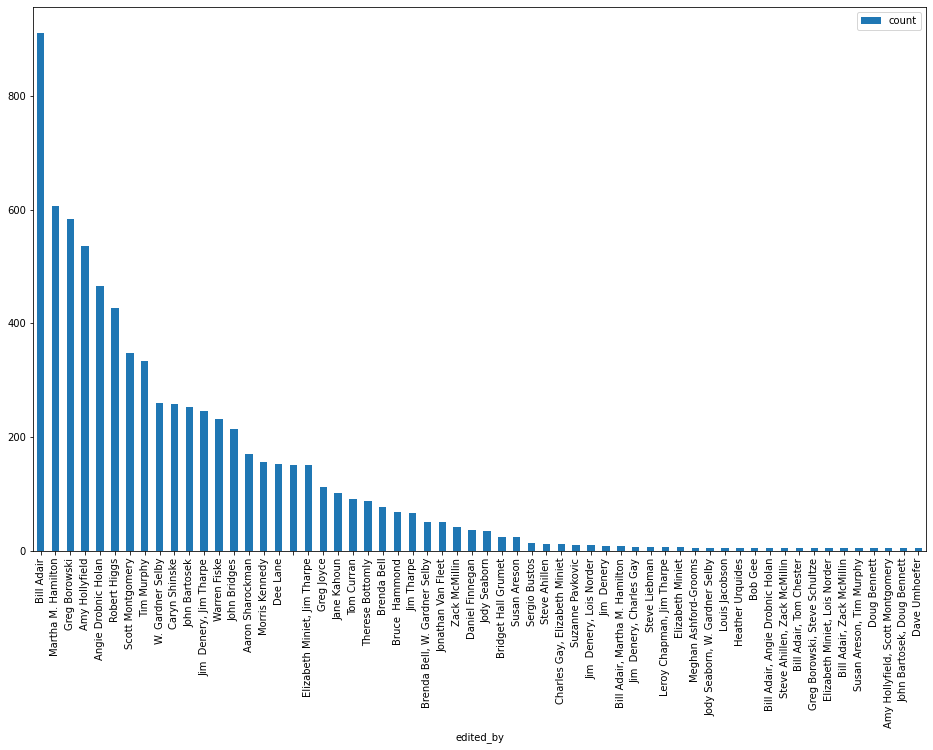

In [11]:
print(np.unique(data['edited_by']))
print(len(np.unique(data['edited_by'])))
data.groupby('edited_by').count()[['state']].rename(
    columns={'state': 'count'}).sort_values(
    'count', ascending=False).reset_index().iloc[:60,:].plot.bar(
        x='edited_by', y='count', figsize=(16, 10), fontsize=10);

In [12]:
print(np.unique(data['researched_by']))
print(len(np.unique(data['researched_by'])))

['' 'Aaron Marshall' 'Aaron Sharockman' 'Aaron Sharockman, Amy Sherman'
 'Adriel Bettelheim' 'Adriel Bettelheim, Angie Drobnic Holan'
 'Adriel Bettelheim, David DeCamp' 'Adriel Bettelheim, Ryan Kelly'
 'Alaina Berner, Christopher Connors, Louis Jacobson' 'Alex Holt'
 'Alex Holt, Louis Jacobson' 'Alex Holt, Michelle Sutherland'
 'Alex Kuffner' 'Alex Leary' 'Alexander Lane' 'Amy Hollyfield'
 'Amy Sherman' 'Amy Sherman, Bartholomew Sullivan' 'Andra Lim'
 'Angie Drobnic Holan' 'Angie Drobnic Holan, Aaron Sharockman'
 'Angie Drobnic Holan, Alex Leary' 'Angie Drobnic Holan, Alexander Lane'
 'Angie Drobnic Holan, Amy Sherman'
 'Angie Drobnic Holan, Amy Sherman, Dave Umhoefer'
 'Angie Drobnic Holan, Catharine Richert'
 'Angie Drobnic Holan, Craig Pittman'
 'Angie Drobnic Holan, David G. Taylor'
 'Angie Drobnic Holan, Ian K. Kullgren'
 'Angie Drobnic Holan, Jeffrey S.  Solochek'
 'Angie Drobnic Holan, John Martin' 'Angie Drobnic Holan, Katie Sanders'
 'Angie Drobnic Holan, Louis Jacobson'
 'Ang

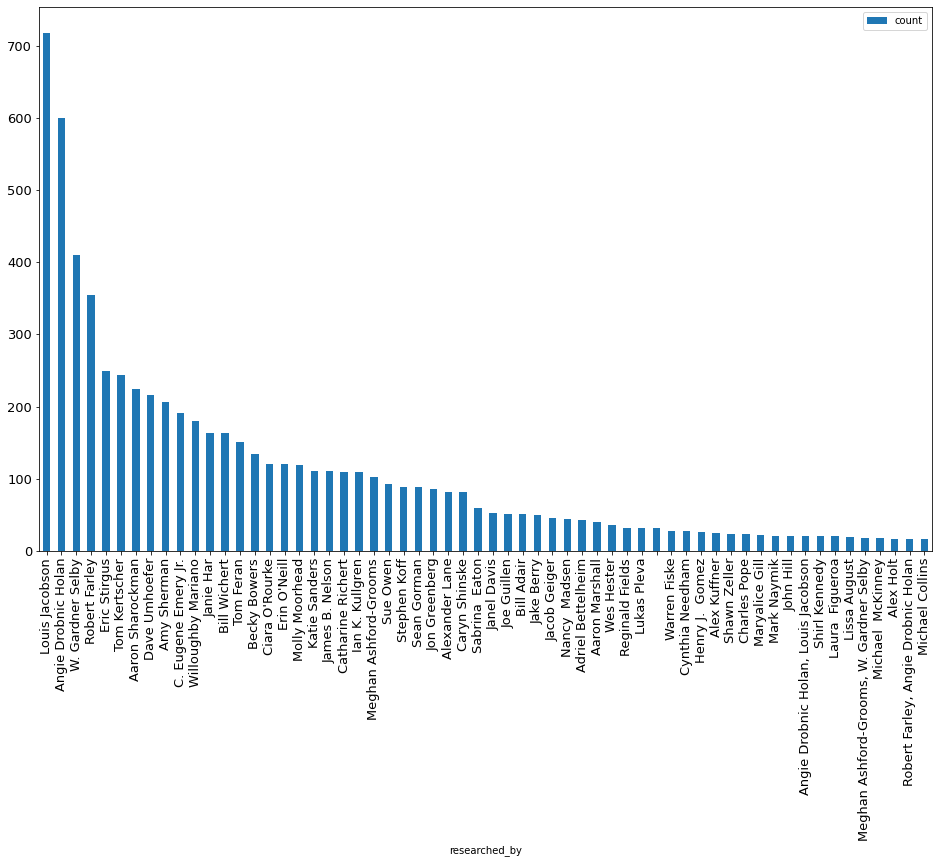

In [13]:
data.groupby('researched_by').count()[['state']].sort_values(
    'state', ascending=False).reset_index().rename(
    columns={'state': 'count'}).iloc[:60,:].plot.bar(
        x='researched_by', y='count', figsize=(16, 10), fontsize=13);

There are 2000+ different sources.

['13th District GOP slate' '18% of the American public'
 '60 Plus Association' ... 'Zell Miller' 'Zoe Lofgren' 'billhislam.com']
2124


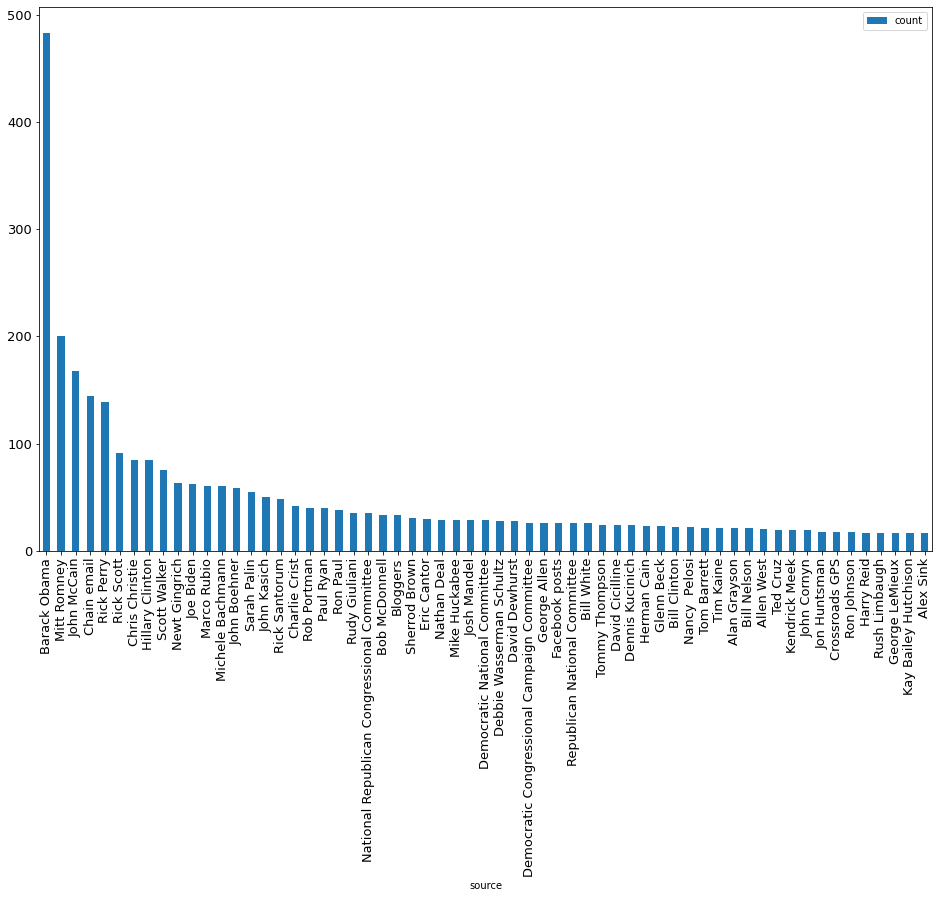

In [14]:
print(np.unique(data['source']))
print(len(np.unique(data['source'])))
data.groupby('source').count()[['state']].rename(
    columns={'state': 'count'}).sort_values(
    'count', ascending=False).reset_index().loc[:60].plot.bar(
        x='source', y='count', figsize=(16, 10), fontsize=13);

### Predicting truth level

The goal is to predict the truthfulness of statements. Let us group the data according to the `truth` columns:

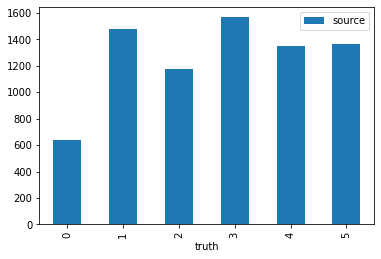

In [15]:
data.groupby('truth').count()[['source']].reset_index().plot.bar(x='truth', y='source');

## The workflow

The pipeline for predicting the 'truth' classification of each statement requires two main steps:  

* feature extraction - which will be used to extract features for classification from the dataset and produce a numpy array of size (number of samples $\times$ number of features). 
* classification - to predict the 'truth' class.

### Feature extraction

The sample solution presented in this starting kit uses **Term Frequency-Inverse Documentation Frequency** (**tf-idf**). A **Term Frequency** (**tf**) is a count of how many times a word occurs in a given document (synonymous with bag of words). The **Inverse Document Frequency** (**idf**) is the number of times a word occurs in a corpus of documents. **tf-idf** is used to weight words according to how important they are. Words that are used frequently in many documents (e.g., 'the', 'is', 'of') has less importance and thus will have a lower weighting while infrequent ones will have a higher weighting.


Built-in scikit-learn functions will be used to implement tf-idf:

[`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) converts a collection of text documents to a matrix of token (*word*) counts. This implementation produces a sparse representation of the counts to be passed to the [`TfidfTransformer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer).
The `TfidfTransformer` transforms a count matrix to a normalized tf or tf-idf representation.

A [`TfidfVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) does both these steps and thus function will be used in our sample solution. 

See the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) for a general introduction to text feature extraction.

In [16]:
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer


preprocessor = make_column_transformer(
    (TfidfVectorizer(analyzer='word'), 'statement'),
    remainder='drop',  # drop all other columns
)

### Classification

The scikit-learn [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) will be used in the sample solution.

### Pipeline

We will use a scikit-learn [pipeline](https://scikit-learn.org/stable/modules/compose.html), which chains together preprocessing and estimator steps, to perform all steps in the workflow. This offers offers convenience and safety (help avoid leaking statistics from your test data into the trained model in cross-validation) and the whole pipeline can be evaluated with [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

Note that the output of `TfidfVectorizer` is a sparse matrix.

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

clf = RandomForestClassifier()

pipeline = make_pipeline(preprocessor, clf)

Before we can evaluate of our pipeline, we must first define the score metric. For this challenge, the official score is smoothed accuracy.

In [18]:
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder

def smooth_acc(y_true, y_proba):
    
    soft_score_matrix = np.array([
        [1, 0.8, 0, 0, 0, 0],
        [0.4, 1, 0.4, 0, 0, 0],
        [0, 0.4, 1, 0.4, 0, 0],
        [0, 0, 0.4, 1, 0.4, 0],
        [0, 0, 0, 0.4, 1, 0.4],
        [0, 0, 0, 0, 0.8, 1],
    ])
    y_true_proba = OneHotEncoder().fit_transform(np.expand_dims(y_true, axis=1))
    # Clip negative probas
    y_proba_positive = np.clip(y_proba, 0, 1)
    # Normalize rows
    y_proba_normalized = y_proba_positive / np.sum(
        y_proba_positive, axis=1, keepdims=True)
    # Smooth true probabilities with score_matrix
    y_true_smoothed = y_true_proba.dot(soft_score_matrix)
    # Compute dot product between the predicted probabilities and
    # the smoothed true "probabilites" ("" because it does not sum to 1)
    scores = np.sum(y_proba_normalized * y_true_smoothed, axis=1)
    scores = np.nan_to_num(scores)
    score = np.mean(scores)
    # to pick up all zero probabilities
    score = np.nan_to_num(score)
    return score
    
smooth_acc_score = make_scorer(smooth_acc, needs_proba=True)

Next we have to define a special cross validation function that splits each train/test iteration using the date that the statement was made. For example, for the first iteration, the test data set will consist of statements made within the first 1/8 of the time period, while the train data set will consist of statements made within the remaining 7/8 of the time period.

To save processing time, `n_splits` is set to 2 below.

In [19]:
from datetime import timedelta

def get_cv(X, n_splits=2):
    """Slice folds by equal date intervals."""
    date = pd.to_datetime(X['date'])
    n_days = (date.max() - date.min()).days
    fold_length = n_days // n_splits
    fold_dates = [date.min() + timedelta(days=i * fold_length)
                  for i in range(n_splits + 1)]
    for i in range(n_splits):
        test_is = (date >= fold_dates[i]) & (date < fold_dates[i + 1])
        test_is = test_is.values
        train_is = ~test_is
        yield np.arange(len(date))[train_is], np.arange(len(date))[test_is]
        
custom_cv = get_cv(X_df)

In [20]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    pipeline, X_df, y_array, cv=custom_cv, scoring=smooth_acc_score
)

print("mean: %e (+/- %e)" % (scores.mean(), scores.std()))

mean: 3.286387e-01 (+/- 3.306209e-03)


This sample solution is implemented in RAMP within `estimator.py`, which is in the folder `submissions/starting_kit`.

`estimator.py` defines a function named `get_estimator` which returns the pipeline detailed above:

In [21]:
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline


def get_estimator():
    
    preprocessor = make_column_transformer(
        (TfidfVectorizer(analyzer='word'), 'statement'),
        remainder='drop',  # drop all other columns
    )
    clf = RandomForestClassifier()
    pipeline = make_pipeline(preprocessor, clf)
    return pipeline
    

## Improving  feature extraction

There are a number of ways to improve the basic solution presented above.

### Preprocessing 

The document preprocessing can be customized in in the `document_preprocessor` function.

For instance, to transform accentuated unicode symbols into their simple counterpart. è -> e, the following function can be used,

In [22]:
import unicodedata

def document_preprocessor(doc):
    doc = unicodedata.normalize('NFD', doc)
    doc = doc.encode('ascii', 'ignore')
    doc = doc.decode("utf-8")
    return str(doc)

see also the `stip_accents` option of [`TfidfVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).


##### Stopword removal
The most frequent words often do not carry much meaning. Examples: *the, a, of, for, in, ...*. 

Stop words removal can be enabled by passing the `stopwords='english'` parameter at the initialization of the
[`TfidfVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). 

A custom list of stop words (e.g. from NLTK) can also be used.

##### Word / character n-grams

By default, the bag of words model is use in the starting kit. To use word or character n-grams, the `analyser` and `ngram_range` parameters of [`TfidfVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) should be changed.


##### Stemming  and Lemmatization

English words like *look* can be inflected with a morphological suffix to produce *looks, looking, looked*. They share the same stem *look*. Often (but not always) it is beneficial to map all inflected forms into the stem. The most commonly used stemmer is the Porter Stemmer. The name comes from its developer, Martin Porter. `SnowballStemmer('english')` from *NLTK* is used. This stemmer is called Snowball, because Porter created a programming language with this name for creating new stemming algorithms.

Stemming can be enabled with a custom `token_processor` function, e.g.

In [23]:
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer('english')

def token_processor(tokens):
    for token in tokens:
        yield stemmer.stem(token)

The document preprocessing and stemmer tokenization function defined above can be added to the `estimator.py` submission like so:

In [24]:
import unicodedata

from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

from nltk.stem import SnowballStemmer


def _document_preprocessor(doc):
    doc = unicodedata.normalize('NFD', doc)
    doc = doc.encode('ascii', 'ignore')
    doc = doc.decode("utf-8")
    return str(doc)


def _token_processor(tokens):
    stemmer = SnowballStemmer('english')
    for token in tokens:
        yield stemmer.stem(token)

def get_estimator():
    vectorizer = TfidfVectorizer(
        analyzer='word', preprocessor=_document_preprocessor, tokenizer=_token_processor
    )
    preprocessor = make_column_transformer(
        (vectorizer, 'statement'),
        remainder='drop',  # drop all other columns
    )
    clf = RandomForestClassifier()
    pipeline = make_pipeline(preprocessor, clf)
    return pipeline

## Submitting to [ramp.studio](http://ramp.studio)

The above submission is a more complex version of the basic sample solution presented above (and within the `submissions/starting_kit/estimator.py` file) and can be used as a guide for your own submission.

Once you have a submission you are happy with, you must <b><span style="color:red">test your submission files locally before submitting them</span></b>.

This can be done by first installing `ramp-workflow` (`pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow)) then running `ramp-test`. For example to rest the example solution, make sure that the python file `estimator.py` is in the  [`submissions/starting_kit`](/tree/submissions/starting_kit) folder, and the data `train.csv` and `test.csv` are in [`data`](/tree/data), then run `ramp-test`. More details about testing RAMP submissions can be found [here](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html#test-a-submission).

`ramp-test` performs exactly the same cross validation as shown above with the function `cross_val_score` (except `n_splits` = 8 for `ramp-test`). The scores from the 8 iterations will be printed to terminal. Note that 3 different accuracy scores are calculated for this challenge but the smooth accuracy ('sacc') is the offical score for this challenge.

Finally, you can submit to [ramp.studio](http://ramp.studio) by following the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html#submitting-to-a-ramp-event).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio).